In [5]:
import sys
!{sys.executable} -m pip install --user pykalman
!{sys.executable} -m pip install --user statsmodels

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
import math
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import statsmodels.tsa.stattools as smts
import statsmodels.api as sm

from matplotlib import pyplot as plt

### Kalman Filter 

In [7]:
# read data
stk1 = pd.read_csv("../ib-data/nyse-daily-tech/DATA.csv")
stk2 = pd.read_csv("../ib-data/nyse-daily-tech/OOMA.csv")
N = min(len(stk1), len(stk2))

stk1 = stk1[-N:].reset_index(drop=True)
stk2 = stk2[-N:].reset_index(drop=True)

# ensure both arrays are of same length
stk1_array = np.log(stk1["close"][:, np.newaxis])
stk2_array = np.log(stk2["close"][:, np.newaxis])

# observation matrix
C = np.hstack((np.ones_like(stk2_array), stk2_array))
C = C.reshape(N, 1, 2)

# state transition matrix
T = np.array([[[1, 0], 
              [0, 1]]])
T = T.repeat(N - 1, axis = 0)

In [8]:
kf = KalmanFilter(em_vars=['transition_covariance', 
                           'observation_covariance', 
                           'initial_state_mean', 
                           'initial_state_covariance'], 
                  transition_matrices=T,
                  observation_matrices=C,
                  n_dim_state=2, 
                  n_dim_obs=1)

In [9]:
kf.em(X=stk1_array, n_iter=50)

In [10]:
filtered_state_means, filtered_state_covariances = kf.filter(X=stk1_array)

In [11]:
filtered_state_means.shape

(874, 2)

### Calculate using both Rolling Least Squares and Kalman Filter

In [169]:
def compute_alpha_beta(Y, X):
    ln_Y = np.log(Y)
    ln_X = np.log(X)
    _X = sm.add_constant(ln_X)

    model = sm.OLS(ln_Y, _X)
    results = model.fit()
    beta, alpha = results.params
    return alpha, beta

def generate_pair_df(df1, df2, train_period=120, history_period=252):
    df1_history, df1_train = df1[:history_period], df1[history_period:history_period + train_period]
    df2_history, df2_train = df2[:history_period], df2[history_period:history_period + train_period]
    df1_test, df2_test = df1[history_period + train_period:], df2[history_period + train_period:]
    
    testing_period = len(df1_test)

    df_combined = pd.DataFrame()

    df_combined["close1"] = df1_test["close"]
    df_combined["logClose1"] = np.log(df1_test["close"])
    df_combined["close2"] = df2_test["close"]
    df_combined["logClose2"] = np.log(df2_test["close"])
    
    ##################################################################################################
    # compute alpha and beta using rolling OLS
    df_combined = df_combined.reset_index(drop=True)
    alpha_t, beta_t = [], []
    for i in range(testing_period):
        # i-th test day
        df1_window = df1[history_period + i : train_period + history_period + i]['close']
        df2_window = df2[history_period + i : train_period + history_period + i]['close']
        a, b = compute_alpha_beta(df1_window, df2_window)
        alpha_t.append(a)
        beta_t.append(b)
    df_combined["rolling_ols_alpha"] = pd.Series(alpha_t)
    df_combined["rolling_ols_beta"] = pd.Series(beta_t)
    
    ##################################################################################################
    # compute alpha and beta using rolling kalman filter
    # 0. define matrices
    stk1_array = np.log(df1_history["close"][:, np.newaxis])
    stk2_array = np.log(df2_history["close"][:, np.newaxis])
    
    # observation matrix
    C = np.hstack((np.ones_like(stk2_array), stk2_array))
    C = C.reshape(history_period, 1, 2)
    
    # state transition matrix
    I = np.array([[[1, 0], 
                  [0, 1]]])
    T = I.repeat(history_period - 1, axis = 0)
    
    kf = KalmanFilter(em_vars=['transition_covariance', 
                           'observation_covariance', 
                           'initial_state_mean', 
                           'initial_state_covariance'], 
                      transition_matrices=T,
                      observation_matrices=C,
                      n_dim_state=2, 
                      n_dim_obs=1)
    
    # 1. EM training on history to estimate sigmas
    kf.em(X=stk1_array, n_iter=50)
    
    # 2. predict new hidden states (one by one) in testing period
    n_timesteps = len(df1)
    filtered_state_means = np.zeros((n_timesteps, 2))
    filtered_state_covariances = np.zeros((n_timesteps, 2, 2))
    filtered_state_means[0:history_period], filtered_state_covariances[0:history_period] = kf.filter(X=stk1_array)
        
    for t in range(history_period - 1, n_timesteps - 1):
        observation_t = np.array([math.log(df1['close'][t])])
        observation_matrix_t = np.array([1, math.log(df2['close'][t])]).reshape(1, 2)
        
        filtered_state_means[t + 1], filtered_state_covariances[t + 1] = (
            kf.filter_update(
                filtered_state_means[t],
                filtered_state_covariances[t],
                observation=observation_t,
                transition_matrix=I.reshape(2, 2),
                observation_matrix=observation_matrix_t
            )
        )
        
    df_combined["kalman_alpha"] = pd.Series(filtered_state_means[-testing_period: , 1])
    df_combined["kalman_beta"] = pd.Series(filtered_state_means[-testing_period: , 0])
    
    return df_combined

In [170]:
# read data
# DATA-OOMA
# AER-XRX
stk1 = pd.read_csv("../ib-data/nyse-daily-tech/DATA.csv")
stk2 = pd.read_csv("../ib-data/nyse-daily-tech/OOMA.csv")
N = min(len(stk1), len(stk2))

stk1 = stk1[-N:].reset_index(drop=True)
stk2 = stk2[-N:].reset_index(drop=True)

In [171]:
rolling_df = generate_pair_df(stk1, stk2)
rolling_df.shape

(502, 8)

### Compare

In [172]:
rolling_df

,close1,logClose1,close2,logClose2,rolling_ols_alpha,rolling_ols_beta,kalman_alpha,kalman_beta
0,44.975,3.806107,9.325,2.232699,-1.063745,6.237186,0.324343,3.082646
1,45.255,3.812313,9.475,2.248657,-1.079314,6.270529,0.323833,3.083175
2,45.195,3.810986,9.125,2.211018,-1.087001,6.286762,0.325653,3.079909
3,45.210,3.811318,9.350,2.235376,-1.077062,6.263896,0.257312,3.240956
4,44.765,3.801427,9.225,2.221917,-1.079852,6.269206,0.250006,3.253063
5,45.055,3.807884,9.075,2.205523,-1.077081,6.261783,0.270918,3.200354
6,44.240,3.789629,8.975,2.194443,-1.070611,6.246589,0.232922,3.293010
7,44.490,3.795264,8.975,2.194443,-1.058894,6.219447,0.279095,3.178839
8,44.825,3.802766,8.975,2.194443,-1.047778,6.193616,0.272196,3.197478
9,44.905,3.804549,9.075,2.205523,-1.027069,6.146850,0.259689,3.231953


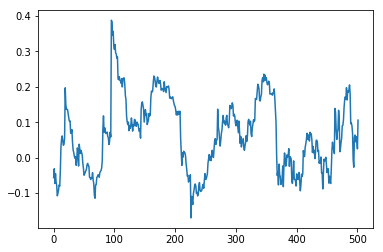

In [173]:
plt.plot(rolling_df["logClose1"] - rolling_df["logClose2"] * rolling_df["rolling_ols_alpha"] - rolling_df["rolling_ols_beta"])
plt.show()

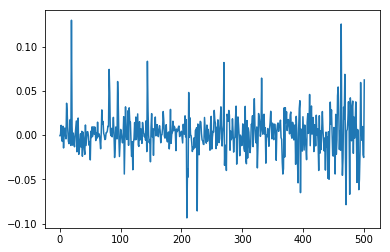

In [174]:
plt.plot(rolling_df["logClose1"] - rolling_df["logClose2"] * rolling_df["kalman_alpha"] - rolling_df["kalman_beta"])
plt.show()

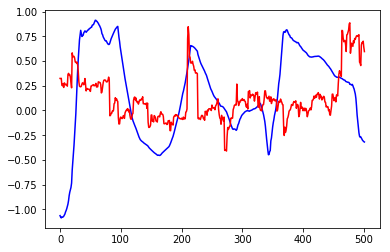

In [175]:
plt.plot(rolling_df["rolling_ols_alpha"], color='b')
plt.plot(rolling_df["kalman_alpha"], color='r')
plt.show()

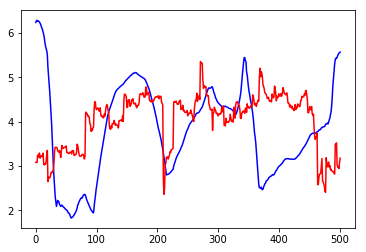

In [176]:
plt.plot(rolling_df["rolling_ols_beta"], color='b')
plt.plot(rolling_df["kalman_beta"], color='r')
plt.show()

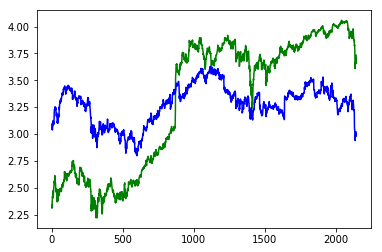

In [161]:
plt.plot(rolling_df['logClose1'], color = 'g')
plt.plot(rolling_df['logClose2'], color = 'b')
plt.show()